# GPU implementation of Bfastmonitor using Python
The bfast package provides a highly-efficient parallel implementation for the Breaks For Additive Season and Trend (BFASTmonitor) proposed by Verbesselt et al. The implementation is based on OpenCL.

The script below runs bfastmonitor over the timeseries data downloaded in SEPAL in blocks, and patches together tiles to export mean magnitudes and breaks .npy files. The output is also displayed in a digital map. Make sure to run through the cells sequentially and keep the parameters constant if you are running over multiple directories of you Area of Interest.

* First download data using the SEPAL time series downloader (not in this script). The downloads will be saved in your downloads folder and look like: /home/'username'/downloads/Time_series_2020-09-01_16-22-26/0|1|2|3

* Import packages

* Select data

* Set parameters

* Select monitoring period*

* Run bfastmonitor*

* Optional: Load output*

* Merge and save tiles output

* Display output

*After saving the output, one may load it in again instead of running bfastmonitor again


### Import packages

In [5]:
import os
from os.path import expanduser

import wget
import numpy as np
from datetime import datetime
import copy
import matplotlib
import matplotlib.pyplot as plt

import json

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal, gdal_array, osr

import time
from tqdm import tqdm

import ipywidgets as widgets
from ipywidgets import Layout
from ipyfilechooser import FileChooser
import folium

from PIL import Image
from matplotlib import cm

# import functions from functions.py and plotting_funcs.py
from functions import set_base_output_dir, set_output_dir, get_data_dict, merge_tiles, set_paths, _find_index_date, normalize 
from plotting_funcs import save_plot, merge_plots, classify_output, plot_output_matplotlib, set_corners

# Import the Timeseries class from time_series.py
from time_series import Timeseries
print(Timeseries.__doc__)

# Import widgets for GUI parameter selection
from widgets import get_widgets, get_dates_widgets
output_directory_chooser, k_chooser,freq_chooser,trend_chooser,hfrac_chooser,level_chooser,backend_chooser, load_chooser, block_size_chooser, plot_display_data_chooser = get_widgets()


    The timeseries class is a wrapper for using SEPAL timeseries data with bfast. 
    It wraps together a data tile with associated dates file and metadata. 
    It also allows for saving and loading the output rasters in a specified directory. 
    


In [6]:
%matplotlib inline

### Select data

#### Select a name for your output folder. All the segments you run through will be saved here: "./stored_time_series/[yourfoldername]



In [7]:
display(output_directory_chooser)

interactive(children=(Text(value='', description='Output storage name: (country/location name, e.g. "Guyana")'…

In [4]:
base_output_dir = set_base_output_dir(output_directory_chooser)

Defaulting to output directory name: stored_time_series/output


#### Select a time series segment folder using ipyfilechooser.  The standard download location is in downloads/time_series_name/[0,1,2..n]


In [6]:
path = expanduser("~")
file_chooser = FileChooser(path)
display(file_chooser)

FileChooser(path='/home/dven', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden…

In [7]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)
    output_dir = set_output_dir(output_directory_chooser,timeseries_directory)
    print(output_dir)

/home/dven/downloads/Time_series_2020-07-07_11-51-35_Portugal/1/
stored_time_series/Portugal_small/Portugal_small_1


#### Load in data: if there are tiles in the directory, create a list and load per tile. The Timeseries tiles and their associated data are put in the list: 'data_list'


In [8]:
# Create Timeseries class objects for every tile
data_list = set_paths(timeseries_directory = timeseries_directory)
for tile in data_list:
    print(tile)

No tiles, setting up data as one tile
Timeseries class holding 529 dates, sized 14 by 8.


### Check some metadata of the created Timeseries class

In [9]:
print("projection: ", data_list[0].projection)
print("pixel size: ", data_list[0].xpixelsize)
print("n dates in timeseries: ", data_list[0].nbands)

# Uncomment to see al vars associated with the tile
#vars(data_list[0])

projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
pixel size:  0.0002694945852358568
n dates in timeseries:  529


# Set parameters

## Make sure not to re-run these blocks if you want to use the same dates for every segment 1|2|3|4

In [10]:
# Choose parameters
display(k_chooser)
display(freq_chooser)
display(trend_chooser)
display(hfrac_chooser)
display(level_chooser)
display(backend_chooser)

interactive(children=(Dropdown(description='k, harmonic terms', index=2, layout=Layout(height='auto', width='5…

interactive(children=(IntSlider(value=365, description='freq, frequency of seasonal model (days)', layout=Layo…

interactive(children=(Checkbox(value=True, description='add trend', layout=Layout(height='auto', width='500px'…

interactive(children=(FloatSlider(value=0.25, description='Bandwith relative to sample size', layout=Layout(he…

interactive(children=(SelectionSlider(description='Significance level of the monitoring', layout=Layout(height…

interactive(children=(Dropdown(description='backend', layout=Layout(height='auto', width='500px'), options=('o…

In [11]:
# Set parameters
k = k_chooser.result
freq = freq_chooser.result
trend = trend_chooser.result
hfrac = hfrac_chooser.result
level = 1 - level_chooser.result
backend = backend_chooser.result
verbose = 1
device_id = 0

# Select monitoring period

## Make sure not to re-run these blocks if you want to use the same dates for every segment 1|2|3|4

In [12]:
dates = data_list[0].dates
start_date = dates[0] # 0 or 10 does not work.. 100 did ########
end_date = dates[-1]
pandas_dates = pd.date_range(start_date, end_date, freq='D')

options =  [(date.strftime('%Y-%m-%d'),date) for date in pandas_dates]
index = (0, len(options)-1)

monitoring_period_chooser, history_period_chooser = get_dates_widgets(options = options, index = index)

display(monitoring_period_chooser)
display(history_period_chooser)

interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 7456), …

interactive(children=(SelectionSlider(description='Start history period:', options=(('2000-01-08', Timestamp('…

In [13]:
start_monitor, end_monitor = monitoring_period_chooser.result
start_hist = history_period_chooser.result

if history_period_chooser.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")
if start_monitor < dates[50]:
    raise Warning("Your history period is relatively short, did you move the monitoring date range to a later date?")

# start_monitor = datetime(2018, 9, 14)



## Loop over tiles, (or single tile), in data_list
### Alternatively, if your magnituede_changes and breaks arrays already exist, skip this code and run load from file in the next block
### If you get a memory error, change the x_block and y_block size to a smaller power of 2: 1080, 512, 256, 128

In [14]:
display(block_size_chooser)

interactive(children=(Dropdown(description='block size, bigger is generally faster, but may result in memory i…

In [15]:
x_block = y_block = block_size_chooser.result

# loading bar
with tqdm(total=len(data_list)) as pbar1:
    
    # loop over tile(s) in the data_list
    for counter, tile in enumerate(data_list):
        pbar1.set_description("Processing tile %s out of %s" % (counter+1, len(data_list)) )

        tile.set_bfast_parameters(start_monitor = start_monitor, 
                                     end_monitor = end_monitor,
                                     start_hist = start_hist,
                                     freq = freq,
                                     k = k,
                                     hfrac = hfrac,
                                     trend = trend,
                                     level = level,
                                     backend=backend,
                                     verbose=verbose,
                                     device_id=device_id)
        
        tile.get_bfast_parameters()
        
        tile.loop_blocks(x_block_size = x_block,
                            y_block_size=y_block)
        
        tile.log_all_output(output_dir_name=output_dir)
        
        pbar1.update(counter)
        
pbar1.close()

# Store the cropped dates for optional loading later
with open(output_dir + "/cropped_dates.csv","w") as f:
    for date in data_list[0].cropped_dates:
        f.write(date.strftime("%m/%d/%Y"))
        f.write("\n")


Processing tile 1 out of 1:   0%|          | 0/1 [00:00<?, ?it/s]
  0%|          | 0/0.001708984375 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/0.001708984375 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4705370>]
Monitoring starts at:  2010-11-09 00:00:00
Monitoring ends at:  2020-06-07 00:00:00
Dataset history starts at:  2000-01-08 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  True
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  14 8
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [14, 8]
set blocksize explicitly:  256 ,  256
start monitor:  2010-11-09 00:00:00
end monitor:  2020-06-07 00:00:00
start history:  2000-01-08 00:00:00
0 0 14 8


Processing blocks of tile:: : 1it [00:02,  2.84s/it]                          
Processing tile 1 out of 1:   0%|          | 0/1 [00:02<?, ?it/s]

--- runtime for data initialization:		0.002246379852294922
--- runtime for data transfer (host->device):	0.0002491474151611328
--- runtime for data preprocessing:		0.00042819976806640625
--- runtime for kernel execution:		0.0019059181213378906
--- runtime for data transfer (device->host):	0.00013875961303710938
Fitting model over all blocks took 2.8458828926086426 seconds.


### If you want to load previously saved files. Only do this if you have saved tiles previously

In [16]:
display(load_chooser)

interactive(children=(Checkbox(value=False, description='load tiles', layout=Layout(height='auto', width='500p…

In [17]:
if load_chooser.result == True:
    
    for tile in data_list:

        with open(output_dir + "/cropped_dates.csv","r") as f:
            dates_list = f.read().split('\n')
            tile.cropped_dates = [datetime.strptime(d, '%m/%d/%Y') for d in dates_list if len(d) > 0]
        
        tile.start_hist = tile.cropped_dates[0]
        tile.end_monitor = tile.cropped_dates[-1]
        tile.load_breaks_means_arrays_from_file(output_dir_name = output_dir)
        
else:
    print("no tiles loaded, make sure to run the block above and uncheck the marker, if you want to load tiles")
    


no tiles loaded, make sure to run the block above and uncheck the marker, if you want to load tiles


### Check tiles for output quality

In [18]:
for tile in data_list:
    print(tile.dir)
    
    # do some plots
    breaks = tile.breaks_array
    means = tile.means_array
    
    tile.check_arrays(min_perc_lacking_data = 50)


/home/dven/downloads/Time_series_2020-07-07_11-51-35_Portugal/1/
minus2s:  0
minus1s:  69
total 112
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 38.392857142857146
amount of nans in means:  1


### Merge tiles together and save as all_means.npy and all_breaks.npy

In [19]:
if len(data_list) > 1:
    big_means_array, big_breaks_array = merge_tiles(data_list,output_dir_name = output_dir)

#### Select negative magnitudes

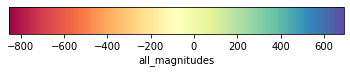

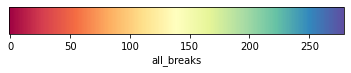

In [20]:
if len(data_list)>1:
    means = big_means_array
    breaks = big_breaks_array
else:
    means = data_list[0].means_array
    breaks = data_list[0].breaks_array

save_plot(means,output_dir, save_name = "all_magnitudes")
save_plot(breaks,output_dir, save_name = "all_breaks")

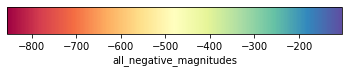

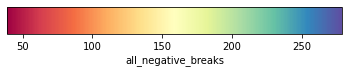

In [21]:
# select only negative magnitudes
no_breaks_indices = (breaks == -1)
means[no_breaks_indices] = np.nan
means[means > 0] = np.nan # only want negative mean changes

breaks_plot = breaks.astype(np.float)
breaks_plot[breaks == -2] = np.nan
breaks_plot[breaks == -1] = np.nan
breaks_plot[means >= 0] = np.nan

save_plot(means, output_dir, save_name = "all_negative_magnitudes")
save_plot(breaks_plot, output_dir, save_name = "all_negative_breaks")


In [22]:
dates_monitor = []
dates = data_list[0].cropped_dates

# collect dates for monitor period
for i in range(len(dates)):
    if start_monitor <= dates[i]:
        dates_monitor.append(dates[i])
dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period

dates_array

array([datetime.datetime(2010, 12, 13, 0, 0),
       datetime.datetime(2011, 4, 28, 0, 0),
       datetime.datetime(2011, 5, 14, 0, 0),
       datetime.datetime(2011, 5, 30, 0, 0),
       datetime.datetime(2011, 8, 18, 0, 0),
       datetime.datetime(2011, 9, 3, 0, 0),
       datetime.datetime(2011, 9, 19, 0, 0),
       datetime.datetime(2011, 10, 5, 0, 0),
       datetime.datetime(2011, 10, 21, 0, 0),
       datetime.datetime(2011, 11, 6, 0, 0),
       datetime.datetime(2011, 3, 19, 0, 0),
       datetime.datetime(2011, 4, 4, 0, 0),
       datetime.datetime(2011, 7, 25, 0, 0),
       datetime.datetime(2011, 8, 10, 0, 0),
       datetime.datetime(2011, 10, 13, 0, 0),
       datetime.datetime(2011, 10, 29, 0, 0),
       datetime.datetime(2012, 2, 2, 0, 0),
       datetime.datetime(2012, 2, 18, 0, 0),
       datetime.datetime(2012, 3, 5, 0, 0),
       datetime.datetime(2012, 3, 21, 0, 0),
       datetime.datetime(2012, 5, 24, 0, 0),
       datetime.datetime(2012, 6, 25, 0, 0),
       dat

# Classify output for plotting

{2010: 0, 2011: 1, 2012: 16, 2013: 28, 2014: 57, 2015: 89, 2016: 130, 2017: 171, 2018: 210, 2019: 244, 2020: 281}


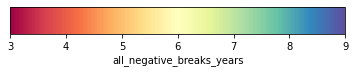

In [23]:
breaks_plot_years, idx_starts = classify_output(start_monitor,end_monitor,breaks_plot,dates_array)
save_plot(breaks_plot_years, output_dir, save_name = "all_negative_breaks_years")

# Plot output

In [25]:
plot_output_matplotlib(idx_starts,breaks_plot_years,ticklist)
save_plot(breaks_plot_years, output_dir, save_name = "breaks_per_year")

NameError: name 'ticklist' is not defined

In [26]:

set_corners(output_dir,data_list)

min_lat  40.701497713586164
max_lat  40.701497713586164
min_lon  -8.420088821109099
max_lon  -8.420088821109099


## Plot all of your segments and save as a html map

In [38]:
display(plot_display_data_chooser)

interactive(children=(Dropdown(description='data to plot', index=2, layout=Layout(height='auto', width='500px'…

In [39]:
from folium.plugins import FloatImage
import base64

import json
# have the user choose a type of output plot with a widget 
#plot_name = "all_negative_means.png"


m = merge_plots(base_output_dir=base_output_dir,plot_name=plot_display_data_chooser.result + ".png")

#m = merge_plots(base_output_dir=base_output_dir,plot_name="breaks_per_year.png")


####
# resolution, width, height = 75, 4,4
# encoded = base64.b64encode(open("output/testcolorbar.png", 'rb').read()).decode()
# from folium import IFrame

# html = '<img src="data:image/png;base64,{}">'.format
# iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)
# popup = folium.Popup(iframe, max_width=2650)

# icon = folium.Icon(color="red", icon="ok")
# marker = folium.Marker([data_list[0].latitude, data_list[0].longitude], popup=popup, icon=icon)
# marker.add_to(m)
####


#m.save('output/' + output_directory_chooser.result + "_" + plot_display_data_chooser.result + ".html")
m

Guyana_0
Guyana_6


FileNotFoundError: [Errno 2] No such file or directory: 'stored_time_series/Guyana/Guyana_6/corners.json'

In [ ]:
# from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker
# from ipyleaflet import Map, LayersControl, ImageOverlay

# m = Map(center=(max_lat, min_lon), zoom=8)
# url = "stored_time_series/Guyana/image.png"

# image = ImageOverlay(url = url,
#                      bounds=((min_lat, min_lon), (max_lat, max_lon)))

# m.add_layer(Marker(location=(max_lat, min_lon)))

# control = LayersControl(position='topright')
# m.add_control(control)
# m.add_layer(image);

# m

# #m.save('my_map.html', title='My Map')